In [1]:
import torch.nn as nn
import torch
import torchvision.models as models
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import os
import math

# summary

    https://www.cnblogs.com/skyfsm/p/6806246.html 基于深度学习的目标检测技术演进：R-CNN、Fast R-CNN、Faster R-CNN
    
    https://blog.csdn.net/u013293750/article/details/64904681 CNN+LSTM深度学习文字检测
    
    https://blog.csdn.net/forest_world/article/details/78566737 主流ocr算法：CNN+BLSTM+CTC架构
    
    https://blog.csdn.net/slade_ruan/article/details/78301842?utm_source=blogxgwz1 场景文本检测，CTPN tensorflow版本
    
    https://blog.csdn.net/Quincuntial/article/details/79475339?utm_source=blogxgwz1 CTPN论文翻译——中英文对照
    
    http://lib.csdn.net/article/deeplearning/61632  通过代码理解faster-RCNN中的RPN
    
    https://slade-ruan.me/2017/10/22/text-detection-ctpn/  论文阅读与实现--CTPN

    https://www.cnblogs.com/freeweb/p/6548208.html

    https://deepsense.ai/region-of-interest-pooling-in-tensorflow-example/

    https://www.cnblogs.com/king-lps/p/9031568.html

# create data

In [ ]:
# 生成训练、测试数据

# data ready

In [5]:
from lib.datasets.factory import get_imdb
from lib.datasets.pascal_voc import pascal_voc
from lib.roi_data_layer.roidb import prepare_roidb
from lib.roi_data_layer.layer import RoIDataLayer


imdb = pascal_voc('trainval', '2007')
# roidb ROI框的坐标位置信息, 信息来源于Annotations目录下对图片的XML定义
prepare_roidb(imdb)   #  为方便训练，在原roidb信息基础上增加象image等等信息
roidb = imdb.roidb 
data_layer = RoIDataLayer(roidb, imdb.num_classes)

<bound method imdb.default_roidb of <lib.datasets.pascal_voc.pascal_voc object at 0x0000029135E2C6A0>>
voc_2007_trainval gt roidb loaded from D:\PROJECT_TW\git\data\voc_2007_trainval_gt_roidb.pkl


In [9]:
blobs = data_layer.forward()

train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\3.jpg


# model

In [14]:
RPN_CHANNELS = 512
TRUNCATED = False
class DataMul(nn.Module):
    def __init__(self, in_size, out_dim, bias= True):
        super(DataMul, self).__init__()
        self.in_size = in_size
        self.out_dim = out_dim
        self.weight = torch.nn.Parameter(torch.Tensor(in_size, out_dim))
        if bias:
            self.bias = torch.nn.Parameter(torch.Tensor(out_dim))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()
        
    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)    
    
    def forward(self, input):
        out = input.matmul(self.weight) + self.bias
        return out
    
    def extra_repr(self):
        return 'in_size={}, out_dim={}, bias={}'.format(
            self.in_size, self.out_dim, self.bias)   
    
class Network(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)
        self._predictions = {}
        self._losses = {}
        self._anchor_targets = {}
        self._proposal_targets = {}
        self._layers = {}
        self._gt_image = None
        self._act_summaries = {}
        self._score_summaries = {}
        self._event_summaries = {}
        self._image_gt_summaries = {}
        self._variables_to_fix = {}

    def create_architecture(self, num_classes, tag=None,anchor_scales=(16,), anchor_ratios=(0.5, 1, 2)):
        self._tag = tag
        self._num_classes = num_classes
        self._anchor_scales = anchor_scales
        self._num_scales = len(anchor_scales)
        self._anchor_ratios = anchor_ratios
        self._num_ratios = len(anchor_ratios)
        self._num_anchors = 10
        assert tag != None
        # Initialize layers
        self._init_modules()
        
    def _init_modules(self):
        self._init_head_tail()
        # rpn
        self.rpn_net = nn.Conv2d(self._net_conv_channels, RPN_CHANNELS, [3, 3], padding=1)
        self.rpn_bi_net = nn.LSTM(RPN_CHANNELS, 256, batch_first=True, bidirectional=True)
#         self.rpn_cls_score_net = nn.LSTM(RPN_CHANNELS, self._num_anchors * 2, batch_first=True, bidirectional=False)
#         self.rpn_bbox_pred_net = nn.LSTM(RPN_CHANNELS, self._num_anchors * 4, batch_first=True, bidirectional=False)
        self.rpn_cls_score_net = DataMul(RPN_CHANNELS, self._num_anchors * 2)
        self.rpn_bbox_pred_net = DataMul(RPN_CHANNELS, self._num_anchors * 4)
        self.init_weights()    
        
    # 对构建的网络参数（weight, bias）进行正则、初始化
    def init_weights(self):
        def normal_init(m, mean, stddev, truncated=False):
            """
                weight initalizer: truncated normal and random normal.
            """
            # x is a parameter
            if isinstance(m, nn.LSTM):
                init.xavier_normal_(m.all_weights[0][0])
                init.xavier_normal_(m.all_weights[0][1])
                if len(m.all_weights) == 2:   # 双向  LSTM
                    init.xavier_normal_(m.all_weights[1][0])
                    init.xavier_normal_(m.all_weights[1][1])
            else:
                if truncated:
                    m.weight.data.normal_().fmod_(2).mul_(stddev).add_(mean)  # not a perfect approximation
                else:
                    m.weight.data.normal_(mean, stddev)
                m.bias.data.zero_()
        normal_init(self.rpn_net, 0, 0.01, TRUNCATED)
#         normal_init(self.rpn_cls_score_net,0, 0.01, TRUNCATED)
#         normal_init(self.rpn_bbox_pred_net,0, 0.01, TRUNCATED)
        normal_init(self.rpn_bi_net,0, 0.01, TRUNCATED)
        

In [15]:
class vgg16(Network):
    def __init__(self):
        Network.__init__(self)
        self._feat_stride = [16, ]
        self._feat_compress = [1. / float(self._feat_stride[0]), ]
        self._net_conv_channels = 512
        self._fc7_channels = 4096

    def _init_head_tail(self):
        # 注意， 通过 models.vgg16() 加载的模型是基础模型，是还没有经过训练的模型， 所以需要load_pretrained_cnn从外部载入已训练好的权重信息
        # 而通过 models.vgg16(pretrained=True)，则是已训练好的模型，无需再加载模型，本次实现采用models.vgg16(pretrained=True)，无需再加载了
        # 注意预加载的是识别图像的（对于识字的需做更改）
        self.vgg = models.vgg16_bn(pretrained=True)
        # Remove fc8
        self.vgg.classifier = nn.Sequential(*list(self.vgg.classifier._modules.values())[:-1])

        # Fix the layers before conv3:
        for layer in range(12):
            for p in self.vgg.features[layer].parameters(): 
                p.requires_grad = False

        # not using the last maxpool layer
        self._layers['head'] = nn.Sequential(*list(self.vgg.features._modules.values())[:-1])
#         print(self._layers['head'])


    # 通过卷积网络VG16的feature层，抽取图片的特征
    def _image_to_head(self):
        net_conv = self._layers['head'](self._image)
        self._act_summaries['conv'] = net_conv
        return net_conv

    def _head_to_tail(self, pool5):
        pool5_flat = pool5.view(pool5.size(0), -1)
        fc7 = self.vgg.classifier(pool5_flat)
        return fc7


    # 注意， 通过 models.vgg16() 加载的模型是基础模型，是还没有经过训练的模型， 所以需要该方法从外部载入权重信息
    # 而通过 models.vgg16(pretrained=True)，则是已训练好的模型，无需再加载模型，本次实现采用models.vgg16(pretrained=True)，
    # 无需再加载了
    def load_pretrained_cnn(self, state_dict):
        self.vgg.load_state_dict({k:v for k,v in state_dict.items() if k in self.vgg.state_dict()})


# train

In [16]:
# https://blog.csdn.net/garfielder007/article/details/51378296  Python numpy函数hstack() vstack() stack() dstack() vsplit() concatenate()
from lib.layutils.generate_anchors import generate_anchors
import lib.layutils.anchor_target_layer as atl
import numpy as np
DEBUG_IN = False
def generate_anchors_pre(height, width, feat_stride, anchor_scales=(8,16,32), anchor_ratios=(0.5,1,2)):
    """ A wrapper function to generate anchors given different scales
    Also return the number of anchors in variable 'length'
    """
    anchors = generate_anchors(ratios=np.array(anchor_ratios), scales=np.array(anchor_scales))
    A = anchors.shape[0]
    shift_x = np.arange(0, width) * feat_stride
    shift_y = np.arange(0, height) * feat_stride
    shift_x, shift_y = np.meshgrid(shift_x, shift_y)
    shifts = np.vstack((shift_x.ravel(), shift_y.ravel(), shift_x.ravel(), shift_y.ravel())).transpose()
    K = shifts.shape[0]
    # width changes faster, so here it is H, W, C
    anchors = anchors.reshape((1, A, 4)) + shifts.reshape((1, K, 4)).transpose((1, 0, 2))
    anchors = anchors.reshape((K * A, 4)).astype(np.float32, copy=False)
    length = np.int32(anchors.shape[0])
    return anchors, length

def _anchor_target_layer(rpn_cls_score, gt_boxes, im_info, feat_stride, anchors, num_anchors):
#     print('_anchor_target_layer begin .... 开始 。。。。')
    rpn_labels, rpn_bbox_targets, rpn_bbox_inside_weights, rpn_bbox_outside_weights = atl.anchor_target_layer(
        rpn_cls_score.data,
        gt_boxes.data.numpy(),
        im_info,
        feat_stride,
        anchors.data.numpy(),
        num_anchors)

    rpn_labels = torch.from_numpy(rpn_labels).float() #.set_shape([1, 1, None, None])
    rpn_bbox_targets = torch.from_numpy(rpn_bbox_targets).float() #.set_shape([1, None, None, self._num_anchors * 4])
    rpn_bbox_inside_weights = torch.from_numpy(rpn_bbox_inside_weights).float() #.set_shape([1, None, None, self._num_anchors * 4])
    rpn_bbox_outside_weights = torch.from_numpy(rpn_bbox_outside_weights).float() #.set_shape([1, None, None, self._num_anchors * 4])
    rpn_labels = rpn_labels.long()
#     self._anchor_targets['rpn_labels'] = rpn_labels
#     self._anchor_targets['rpn_bbox_targets'] = rpn_bbox_targets
#     self._anchor_targets['rpn_bbox_inside_weights'] = rpn_bbox_inside_weights
#     self._anchor_targets['rpn_bbox_outside_weights'] = rpn_bbox_outside_weights
#     for k in self._anchor_targets.keys():
#         self._score_summaries[k] = self._anchor_targets[k]
    

    return rpn_labels,rpn_bbox_targets,rpn_bbox_inside_weights,rpn_bbox_outside_weights


def _smooth_l1_loss(bbox_pred, bbox_targets, bbox_inside_weights, bbox_outside_weights, sigma=1.0, dim=[1]):
    sigma_2 = sigma ** 2
    box_diff = bbox_pred - bbox_targets
    in_box_diff = bbox_inside_weights * box_diff
    abs_in_box_diff = torch.abs(in_box_diff)
    smoothL1_sign = (abs_in_box_diff < 1. / sigma_2).detach().float()
    in_loss_box = torch.pow(in_box_diff, 2) * (sigma_2 / 2.) * smoothL1_sign \
                  + (abs_in_box_diff - (0.5 / sigma_2)) * (1. - smoothL1_sign)
    out_loss_box = bbox_outside_weights * in_loss_box
    loss_box = out_loss_box
    for i in sorted(dim, reverse=True):
        loss_box = loss_box.sum(i)
    loss_box = loss_box.mean()
    return loss_box

def _add_loss(rpn_cls_score_reshape,rpn_labels,
              rpn_bbox_pred,
              rpn_bbox_targets,
              rpn_bbox_inside_weights,
              rpn_bbox_outside_weights,
             sigma_rpn = 3.0):
#     loss_fun = nn.MSELoss() 
    rpn_cls_score = rpn_cls_score_reshape.view(-1,2)
#     print('rpn cls score --> \n {}'.format(rpn_cls_score))
#     rpn_cls_score = rpn_cls_score_reshape
    rpn_label = rpn_labels.view(-1)
    rpn_select = (rpn_label.data != -1).nonzero().view(-1)
    rpn_cls_score = rpn_cls_score.index_select(0, rpn_select).contiguous().view(-1, 2)
    rpn_label = rpn_label.index_select(0, rpn_select).contiguous().view(-1)
#     rpn_label = rpn_label.unsqueeze(1)
#     print('rpn labels --> \n {}'.format(rpn_label))
    if DEBUG_IN:
        print('rpn cls score --> \n {}'.format(rpn_cls_score))
        print('rpn label --> \n {}'.format(rpn_label))
    rpn_cross_entropy = F.cross_entropy(rpn_cls_score, rpn_label)
    
    rpn_loss_box = _smooth_l1_loss(rpn_bbox_pred, rpn_bbox_targets, rpn_bbox_inside_weights,
                                          rpn_bbox_outside_weights, sigma=sigma_rpn, dim=[1, 2, 3])
    
    loss = rpn_cross_entropy + rpn_loss_box
#     loss = rpn_cross_entropy
    return loss,rpn_cross_entropy,rpn_loss_box


In [17]:
DEBUG = False
# feat_stride：[16]VGG中conv5_3相比于输入图像缩小了16倍，也就是相邻两个点之间的stride=16 
feat_stride = [16, ]
ANCHOR_SCALES = [16]
ANCHOR_RATIOS = [0.5,1,2]
MOMENTUM = 0.9
lr = 0.0001
DOUBLE_BIAS = True
BIAS_DECAY = False
WEIGHT_DECAY = 0.0005
EPCHO = 5000
num_anchors = 10
RPN_CHANNELS = 512

net = vgg16()
# print(imdb.num_classes)

net.create_architecture(imdb.num_classes, tag='default',
                                            anchor_scales=ANCHOR_SCALES,
                                            anchor_ratios=ANCHOR_RATIOS)
params = []

for key, value in dict(net.named_parameters()).items():
    if value.requires_grad:
        if 'bias' in key:
              params += [{'params':[value],'lr':lr*(DOUBLE_BIAS + 1), 
                  'weight_decay': BIAS_DECAY and WEIGHT_DECAY or 0}]
        else:
              params += [{'params':[value],'lr':lr, 
                  'weight_decay': WEIGHT_DECAY}]
                
if os.path.exists('D:\\PROJECT_TW\\git\\data\\example\\model\\text_detect_new.pkl'):
    net.load_state_dict(torch.load('D:\\PROJECT_TW\\git\\data\\example\\model\\text_detect_new.pkl'))
                

optimizer = torch.optim.SGD(params,lr=lr, momentum=MOMENTUM)

for step in range(EPCHO):
    blobs = data_layer.forward()
    image = torch.from_numpy(blobs['data'].transpose([0,3,1,2]))
    im_info = blobs['im_info']
    gt_boxes = torch.from_numpy(blobs['gt_boxes'])
    net_conv = net._layers['head'](image)
    anchors, length = generate_anchors_pre(net_conv.size(2), net_conv.size(3),feat_stride=feat_stride,anchor_scales=(16,))
    anchors = torch.from_numpy(anchors)
    rpn = F.relu(net.rpn_net(net_conv))  # ( N , C, H, W）
    # ( N , C, H, W）  --》 （N * H, W, C)
    rpn_reshape = rpn.permute(0,2,3,1).squeeze(0)
    
    # 双向LSTM网络   -->  (N*H, W, C)
    rpn_blstm,_ = net.rpn_bi_net(rpn_reshape)
    rpn_blstm = F.relu(rpn_blstm)  # 注意另外可以考虑采用batch normal方法对数据进行整理
    
    # test detect 采用随机生成 偏移变量数组和得分初始化数组  
    # 与rpn_blsm[N*H*W,C]矩阵相乘方式得到其偏移和分类得分 [N,H,W,4*num anchor或2]
    # 这里暂时用lstm 来代替，后面需改成上述方案实现
    rpn_blstm_reshape = rpn_blstm.view(-1, RPN_CHANNELS)
    rpn_cls_score = net.rpn_cls_score_net(rpn_blstm)   # [W H, num_anchors*2], num_anchors = 10
    rpn_cls_score = rpn_cls_score.view(rpn_blstm.size()[0], rpn_blstm.size()[1],-1)
#     print('rpn cls score size {}'.format(rpn_cls_score.size()))

    rpn_cls_score = rpn_cls_score.permute(2,0,1).unsqueeze(0)
    rpn_cls_score = rpn_cls_score.permute(0,2,3,1)
    # N , H, W, 2*10   --->  N, H ,W * 10, 2
    rpn_cls_score_reshape = rpn_cls_score.contiguous().view(1,rpn_cls_score.size()[1],-1,2)  

    if DEBUG:
        print('rpn cls score shape --> {}'.format(rpn_cls_score.size()))
        print('rpn cls score reshape shape --> {}'.format(rpn_cls_score_reshape.size()))
    
    
    # 得到坐标点的10个分类概率（二分类方法)
    rpn_cls_prob_reshape = F.softmax(rpn_cls_score_reshape.view(-1,2),dim=1)           # N 2 H*NUM_ANCHORS W
    if DEBUG:
        print('rpn cls prob reshape --> \n {}'.format(rpn_cls_prob_reshape))
    
    rpn_bbox_pred  = net.rpn_bbox_pred_net(rpn_blstm_reshape)   # [W H, num_anchors*4], num_anchors = 10
    rpn_bbox_pred = rpn_bbox_pred.view(rpn_blstm.size()[0],rpn_blstm.size()[1],-1)
    rpn_bbox_pred = rpn_bbox_pred.unsqueeze(0)

        
    rpn_labels,rpn_bbox_targets,rpn_bbox_inside_weights,rpn_bbox_outside_weights = _anchor_target_layer(rpn_cls_score,
                                                                                                        gt_boxes,
                                                                                                        im_info,
                                                                                                        feat_stride,
                                                                                                        anchors,
                                                                                                        num_anchors)
#     print('rpn bbox targets --> \n {}'.format(rpn_bbox_targets))
    if DEBUG:
        print('rpn class score reshape size {}  --> \n {}'.format(rpn_cls_score_reshape.size(),rpn_cls_score_reshape.view(-1,2)))
        print('rpn_labels size {}'.format(rpn_labels.size()))
        print('rpn labels {} --> \n {}'.format(rpn_labels.size(), rpn_labels))
        
    loss,cls_loss,box_loss = _add_loss(rpn_cls_score_reshape,rpn_labels,rpn_bbox_pred,
                     rpn_bbox_targets,rpn_bbox_inside_weights,rpn_bbox_outside_weights)
    
    print('{} total loss --> {:.4f} cls loss --> {:.4f} box loss --> {:.4f} '.format(step,loss,cls_loss,box_loss))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if step % 10 == 0:
        print('save model ')
        torch.save(net.state_dict(), 'D:\\PROJECT_TW\\git\\data\\example\\model\\text_detect_new.pkl')
    
    

train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\7.jpg
0 total loss --> 92.7171 cls loss --> 0.7008 box loss --> 92.0163 
save model 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\6.jpg
1 total loss --> 85.9908 cls loss --> 0.6810 box loss --> 85.3097 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\5.jpg
2 total loss --> 60.6700 cls loss --> 0.7447 box loss --> 59.9253 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
3 total loss --> 101.1453 cls loss --> 0.7008 box loss --> 100.4445 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
4 total loss --> 96.8296 cls loss --> 0.7003 box loss --> 96.1293 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\11.jpg
5 total loss --> 85.2711 cls loss --> 0.6869 box loss --> 84.5842 
train image name : num 0 : D:\PROJECT_TW\git\data

51 total loss --> 32.5734 cls loss --> 0.7219 box loss --> 31.8516 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\3.jpg
52 total loss --> 77.1163 cls loss --> 0.7065 box loss --> 76.4097 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\13.jpg
53 total loss --> 59.4367 cls loss --> 0.7065 box loss --> 58.7302 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\6.jpg
54 total loss --> 69.8009 cls loss --> 0.6820 box loss --> 69.1189 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\9.jpg
55 total loss --> 68.7369 cls loss --> 0.6946 box loss --> 68.0423 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\10.jpg
56 total loss --> 30.8363 cls loss --> 0.7213 box loss --> 30.1150 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\13.jpg
57 total loss --> 57.7641 cls loss --> 0.6967 box loss 

train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\6.jpg
103 total loss --> 46.3743 cls loss --> 0.6793 box loss --> 45.6949 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\7.jpg
104 total loss --> 46.0389 cls loss --> 0.6864 box loss --> 45.3525 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
105 total loss --> 60.0288 cls loss --> 0.6882 box loss --> 59.3406 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\3.jpg
106 total loss --> 52.9044 cls loss --> 0.7001 box loss --> 52.2043 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\4.jpg
107 total loss --> 22.6798 cls loss --> 0.6884 box loss --> 21.9914 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\9.jpg
108 total loss --> 39.7270 cls loss --> 0.6892 box loss --> 39.0378 
train image name : num 0 : D:\PROJECT_TW\git\data\VO

train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\9.jpg
154 total loss --> 49.0567 cls loss --> 0.6929 box loss --> 48.3638 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\3.jpg
155 total loss --> 29.0069 cls loss --> 0.6967 box loss --> 28.3102 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\6.jpg
156 total loss --> 47.6790 cls loss --> 0.6849 box loss --> 46.9941 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\7.jpg
157 total loss --> 37.3524 cls loss --> 0.6846 box loss --> 36.6679 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\10.jpg
158 total loss --> 26.8656 cls loss --> 0.7212 box loss --> 26.1444 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\4.jpg
159 total loss --> 21.6990 cls loss --> 0.6847 box loss --> 21.0144 
train image name : num 0 : D:\PROJECT_TW\git\data\V

train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\9.jpg
205 total loss --> 35.5616 cls loss --> 0.6940 box loss --> 34.8676 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
206 total loss --> 24.0757 cls loss --> 0.6839 box loss --> 23.3918 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\5.jpg
207 total loss --> 33.6413 cls loss --> 0.7313 box loss --> 32.9100 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\13.jpg
208 total loss --> 41.1241 cls loss --> 0.6960 box loss --> 40.4281 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\7.jpg
209 total loss --> 34.3364 cls loss --> 0.6871 box loss --> 33.6493 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\6.jpg
210 total loss --> 38.9669 cls loss --> 0.6782 box loss --> 38.2887 
save model 
train image name : num 0 : D:\PROJECT_T

train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\9.jpg
256 total loss --> 31.9077 cls loss --> 0.6925 box loss --> 31.2152 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\13.jpg
257 total loss --> 29.1004 cls loss --> 0.6983 box loss --> 28.4022 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\5.jpg
258 total loss --> 25.9506 cls loss --> 0.7306 box loss --> 25.2199 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\11.jpg
259 total loss --> 25.9941 cls loss --> 0.6866 box loss --> 25.3075 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\7.jpg
260 total loss --> 25.7619 cls loss --> 0.6886 box loss --> 25.0734 
save model 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\13.jpg
261 total loss --> 32.6590 cls loss --> 0.7075 box loss --> 31.9515 
train image name : num 0 : D:\PROJECT

train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\13.jpg
307 total loss --> 29.7995 cls loss --> 0.6851 box loss --> 29.1144 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
308 total loss --> 20.9138 cls loss --> 0.6785 box loss --> 20.2353 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\11.jpg
309 total loss --> 23.3695 cls loss --> 0.6854 box loss --> 22.6841 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\12.jpg
310 total loss --> 32.7381 cls loss --> 0.7064 box loss --> 32.0317 
save model 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\5.jpg
311 total loss --> 26.2455 cls loss --> 0.7254 box loss --> 25.5201 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
312 total loss --> 24.6716 cls loss --> 0.6755 box loss --> 23.9961 
train image name : num 0 : D:\PROJECT

train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\7.jpg
358 total loss --> 23.9449 cls loss --> 0.6762 box loss --> 23.2687 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
359 total loss --> 20.9684 cls loss --> 0.6838 box loss --> 20.2846 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\8.jpg
360 total loss --> 24.4042 cls loss --> 0.6831 box loss --> 23.7210 
save model 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
361 total loss --> 17.3706 cls loss --> 0.6830 box loss --> 16.6876 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\5.jpg
362 total loss --> 23.1074 cls loss --> 0.7145 box loss --> 22.3929 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\6.jpg
363 total loss --> 24.2834 cls loss --> 0.6737 box loss --> 23.6096 
train image name : num 0 : D:\PROJECT_TW

train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\7.jpg
409 total loss --> 16.3259 cls loss --> 0.6687 box loss --> 15.6572 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\5.jpg
410 total loss --> 36.0897 cls loss --> 0.7240 box loss --> 35.3657 
save model 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\4.jpg
411 total loss --> 10.1764 cls loss --> 0.6702 box loss --> 9.5061 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
412 total loss --> 16.6762 cls loss --> 0.6673 box loss --> 16.0089 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\12.jpg
413 total loss --> 29.2981 cls loss --> 0.6892 box loss --> 28.6089 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\10.jpg
414 total loss --> 15.7015 cls loss --> 0.7066 box loss --> 14.9949 
train image name : num 0 : D:\PROJECT_T

train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\12.jpg
460 total loss --> 25.0569 cls loss --> 0.6981 box loss --> 24.3588 
save model 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\13.jpg
461 total loss --> 24.7537 cls loss --> 0.6840 box loss --> 24.0697 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\5.jpg
462 total loss --> 22.2330 cls loss --> 0.7202 box loss --> 21.5128 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\3.jpg
463 total loss --> 13.5800 cls loss --> 0.6729 box loss --> 12.9070 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\13.jpg
464 total loss --> 26.2633 cls loss --> 0.6937 box loss --> 25.5696 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
465 total loss --> 11.5185 cls loss --> 0.6685 box loss --> 10.8500 
train image name : num 0 : D:\PROJECT

train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\11.jpg
511 total loss --> 18.3824 cls loss --> 0.6702 box loss --> 17.7122 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
512 total loss --> 13.2503 cls loss --> 0.6763 box loss --> 12.5740 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\4.jpg
513 total loss --> 8.3631 cls loss --> 0.6742 box loss --> 7.6889 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\5.jpg
514 total loss --> 18.2958 cls loss --> 0.7140 box loss --> 17.5817 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\10.jpg
515 total loss --> 16.2298 cls loss --> 0.6986 box loss --> 15.5311 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\7.jpg
516 total loss --> 20.7234 cls loss --> 0.6669 box loss --> 20.0565 
train image name : num 0 : D:\PROJECT_TW\git\data\VO

train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\11.jpg
562 total loss --> 16.1386 cls loss --> 0.6725 box loss --> 15.4661 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\5.jpg
563 total loss --> 17.9881 cls loss --> 0.7221 box loss --> 17.2661 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\9.jpg
564 total loss --> 16.7366 cls loss --> 0.6623 box loss --> 16.0743 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\10.jpg
565 total loss --> 14.4838 cls loss --> 0.7129 box loss --> 13.7709 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\4.jpg
566 total loss --> 6.6361 cls loss --> 0.6653 box loss --> 5.9708 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
567 total loss --> 11.1228 cls loss --> 0.6853 box loss --> 10.4375 
train image name : num 0 : D:\PROJECT_TW\git\data\VO

train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\12.jpg
613 total loss --> 21.6186 cls loss --> 0.6844 box loss --> 20.9341 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\3.jpg
614 total loss --> 12.6990 cls loss --> 0.6762 box loss --> 12.0228 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\13.jpg
615 total loss --> 20.9154 cls loss --> 0.6859 box loss --> 20.2295 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\5.jpg
616 total loss --> 19.0111 cls loss --> 0.7244 box loss --> 18.2867 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\10.jpg
617 total loss --> 12.4765 cls loss --> 0.7029 box loss --> 11.7735 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\9.jpg
618 total loss --> 18.8497 cls loss --> 0.6605 box loss --> 18.1892 
train image name : num 0 : D:\PROJECT_TW\git\data

train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\6.jpg
664 total loss --> 16.7260 cls loss --> 0.6609 box loss --> 16.0651 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\8.jpg
665 total loss --> 14.7167 cls loss --> 0.6650 box loss --> 14.0517 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
666 total loss --> 12.5234 cls loss --> 0.6708 box loss --> 11.8526 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\4.jpg
667 total loss --> 6.0568 cls loss --> 0.6612 box loss --> 5.3956 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\5.jpg
668 total loss --> 15.6051 cls loss --> 0.7011 box loss --> 14.9040 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\9.jpg
669 total loss --> 13.8033 cls loss --> 0.6691 box loss --> 13.1343 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCd

715 total loss --> 3.9716 cls loss --> 0.6649 box loss --> 3.3068 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\6.jpg
716 total loss --> 15.3185 cls loss --> 0.6596 box loss --> 14.6589 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\9.jpg
717 total loss --> 18.2666 cls loss --> 0.6643 box loss --> 17.6022 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\3.jpg
718 total loss --> 9.2459 cls loss --> 0.6639 box loss --> 8.5820 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\12.jpg
719 total loss --> 16.9821 cls loss --> 0.6836 box loss --> 16.2985 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\7.jpg
720 total loss --> 9.9117 cls loss --> 0.6468 box loss --> 9.2649 
save model 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\8.jpg
721 total loss --> 12.9046 cls loss --> 0.657

train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\13.jpg
767 total loss --> 17.7097 cls loss --> 0.6715 box loss --> 17.0382 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\5.jpg
768 total loss --> 16.5464 cls loss --> 0.7129 box loss --> 15.8335 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
769 total loss --> 11.6392 cls loss --> 0.6748 box loss --> 10.9644 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\7.jpg
770 total loss --> 7.2524 cls loss --> 0.6520 box loss --> 6.6005 
save model 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\3.jpg
771 total loss --> 8.7387 cls loss --> 0.6681 box loss --> 8.0706 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
772 total loss --> 7.1656 cls loss --> 0.6692 box loss --> 6.4964 
train image name : num 0 : D:\PROJECT_TW\git\

818 total loss --> 5.9089 cls loss --> 0.6485 box loss --> 5.2604 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\12.jpg
819 total loss --> 13.0695 cls loss --> 0.6833 box loss --> 12.3862 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
820 total loss --> 4.8131 cls loss --> 0.6737 box loss --> 4.1394 
save model 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\5.jpg
821 total loss --> 19.1652 cls loss --> 0.7124 box loss --> 18.4527 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\9.jpg
822 total loss --> 12.3787 cls loss --> 0.6651 box loss --> 11.7137 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\10.jpg
823 total loss --> 9.7356 cls loss --> 0.7030 box loss --> 9.0326 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\3.jpg
824 total loss --> 7.3146 cls loss --> 0.663

train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\12.jpg
870 total loss --> 14.9559 cls loss --> 0.6615 box loss --> 14.2944 
save model 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\7.jpg
871 total loss --> 8.7269 cls loss --> 0.6527 box loss --> 8.0742 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\3.jpg
872 total loss --> 4.8452 cls loss --> 0.6644 box loss --> 4.1808 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\13.jpg
873 total loss --> 17.1400 cls loss --> 0.6646 box loss --> 16.4754 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
874 total loss --> 8.1922 cls loss --> 0.6736 box loss --> 7.5186 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\9.jpg
875 total loss --> 11.6199 cls loss --> 0.6609 box loss --> 10.9590 
train image name : num 0 : D:\PROJECT_TW\git

921 total loss --> 9.9541 cls loss --> 0.6690 box loss --> 9.2852 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\6.jpg
922 total loss --> 10.9009 cls loss --> 0.6553 box loss --> 10.2457 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\9.jpg
923 total loss --> 10.1764 cls loss --> 0.6576 box loss --> 9.5188 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\8.jpg
924 total loss --> 11.8403 cls loss --> 0.6481 box loss --> 11.1921 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\5.jpg
925 total loss --> 17.3972 cls loss --> 0.7087 box loss --> 16.6885 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\4.jpg
926 total loss --> 2.7891 cls loss --> 0.6559 box loss --> 2.1332 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\12.jpg
927 total loss --> 13.2270 cls loss --> 0.6650 box loss 

train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\10.jpg
973 total loss --> 8.1811 cls loss --> 0.6856 box loss --> 7.4955 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\5.jpg
974 total loss --> 17.1669 cls loss --> 0.7080 box loss --> 16.4589 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\7.jpg
975 total loss --> 7.6159 cls loss --> 0.6469 box loss --> 6.9691 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
976 total loss --> 7.1371 cls loss --> 0.6586 box loss --> 6.4786 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\3.jpg
977 total loss --> 5.1647 cls loss --> 0.6564 box loss --> 4.5083 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\11.jpg
978 total loss --> 6.2565 cls loss --> 0.6490 box loss --> 5.6075 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2

1024 total loss --> 5.6582 cls loss --> 0.6870 box loss --> 4.9711 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\7.jpg
1025 total loss --> 5.2738 cls loss --> 0.6453 box loss --> 4.6285 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\6.jpg
1026 total loss --> 8.9108 cls loss --> 0.6549 box loss --> 8.2559 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\4.jpg
1027 total loss --> 2.7833 cls loss --> 0.6466 box loss --> 2.1367 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\11.jpg
1028 total loss --> 3.5493 cls loss --> 0.6504 box loss --> 2.8989 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
1029 total loss --> 7.4385 cls loss --> 0.6588 box loss --> 6.7797 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
1030 total loss --> 7.5896 cls loss --> 0.6562 box loss -

train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\13.jpg
1076 total loss --> 10.2267 cls loss --> 0.6620 box loss --> 9.5647 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\4.jpg
1077 total loss --> 1.6763 cls loss --> 0.6462 box loss --> 1.0301 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\9.jpg
1078 total loss --> 9.1967 cls loss --> 0.6533 box loss --> 8.5434 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\3.jpg
1079 total loss --> 2.8587 cls loss --> 0.6535 box loss --> 2.2052 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
1080 total loss --> 4.7937 cls loss --> 0.6635 box loss --> 4.1303 
save model 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\6.jpg
1081 total loss --> 9.5162 cls loss --> 0.6547 box loss --> 8.8615 
train image name : num 0 : D:\PROJECT_TW\git

train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\6.jpg
1127 total loss --> 12.5896 cls loss --> 0.6567 box loss --> 11.9329 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\3.jpg
1128 total loss --> 3.8206 cls loss --> 0.6422 box loss --> 3.1784 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\9.jpg
1129 total loss --> 6.7735 cls loss --> 0.6511 box loss --> 6.1225 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\10.jpg
1130 total loss --> 8.9200 cls loss --> 0.6797 box loss --> 8.2403 
save model 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\8.jpg
1131 total loss --> 7.7590 cls loss --> 0.6457 box loss --> 7.1134 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\5.jpg
1132 total loss --> 28.4058 cls loss --> 0.7097 box loss --> 27.6961 
train image name : num 0 : D:\PROJECT_TW\

1178 total loss --> 8.2167 cls loss --> 0.6860 box loss --> 7.5307 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
1179 total loss --> 5.8513 cls loss --> 0.6649 box loss --> 5.1863 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\5.jpg
1180 total loss --> 17.8390 cls loss --> 0.7045 box loss --> 17.1345 
save model 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\6.jpg
1181 total loss --> 15.3508 cls loss --> 0.6436 box loss --> 14.7072 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\11.jpg
1182 total loss --> 6.7127 cls loss --> 0.6493 box loss --> 6.0634 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
1183 total loss --> 6.0995 cls loss --> 0.6516 box loss --> 5.4479 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
1184 total loss --> 3.9085 cls loss --> 0

train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\4.jpg
1230 total loss --> 3.3208 cls loss --> 0.6468 box loss --> 2.6740 
save model 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\8.jpg
1231 total loss --> 5.5783 cls loss --> 0.6461 box loss --> 4.9322 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\12.jpg
1232 total loss --> 9.2919 cls loss --> 0.6655 box loss --> 8.6264 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\6.jpg
1233 total loss --> 7.9596 cls loss --> 0.6443 box loss --> 7.3153 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\7.jpg
1234 total loss --> 3.9928 cls loss --> 0.6363 box loss --> 3.3565 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
1235 total loss --> 3.9508 cls loss --> 0.6573 box loss --> 3.2936 
train image name : num 0 : D:\PROJECT_TW\git\

train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\11.jpg
1281 total loss --> 3.0709 cls loss --> 0.6515 box loss --> 2.4193 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\7.jpg
1282 total loss --> 4.3207 cls loss --> 0.6326 box loss --> 3.6881 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\10.jpg
1283 total loss --> 3.0591 cls loss --> 0.6803 box loss --> 2.3788 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\8.jpg
1284 total loss --> 5.7532 cls loss --> 0.6360 box loss --> 5.1172 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
1285 total loss --> 6.2371 cls loss --> 0.6521 box loss --> 5.5851 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\6.jpg
1286 total loss --> 7.2260 cls loss --> 0.6405 box loss --> 6.5855 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdev

1332 total loss --> 41.6551 cls loss --> 0.7179 box loss --> 40.9372 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\9.jpg
1333 total loss --> 4.7280 cls loss --> 0.6296 box loss --> 4.0983 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\11.jpg
1334 total loss --> 2.1458 cls loss --> 0.6371 box loss --> 1.5086 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\13.jpg
1335 total loss --> 8.4799 cls loss --> 0.6578 box loss --> 7.8220 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\2.jpg
1336 total loss --> 3.5232 cls loss --> 0.6563 box loss --> 2.8670 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg
1337 total loss --> 3.4183 cls loss --> 0.6466 box loss --> 2.7717 
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\6.jpg
1338 total loss --> 6.8817 cls loss --> 0.6399 box los

KeyboardInterrupt: 

In [8]:
rpn_cls_score = rpn_cls_score_reshape.view(-1,2)
rpn_label = rpn_labels.view(-1)
rpn_select = (rpn_label.data != -1).nonzero().view(-1)
rpn_cls_score = rpn_cls_score.index_select(0, rpn_select).contiguous().view(-1, 2)
rpn_label = rpn_label.index_select(0, rpn_select).contiguous().view(-1)
print(rpn_label)
print(rpn_cls_score)


tensor([ 1,  1,  1,  1,  1,  1,  1,  1,  0,  0,  1,  0,  0,  1,
         1,  0,  1,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  0,
         0,  0,  0,  0,  0,  1,  1,  1,  0,  0,  1,  1,  1,  0,
         1,  0,  0,  0,  0,  0,  0,  0,  1,  1,  0,  0,  0,  0,
         0,  1,  1,  1,  1,  1,  1,  0,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  1,  1,  1,  1,  1,  0,  0,  0,  0,  0,  1,  1,  1,
         1,  1,  1,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  0,
         1,  1,  1,  0,  1,  1,  1,  0,  0,  0,  0,  1,  1,  0,
         1,  1,  1,  1,  0,  0,  0,  1,  1,  1,  0,  0,  0,  0,
         0,  0,  1,  1,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,
         1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
         1,  1,  1,  0,  1,  1,  1,  0,  1,  1,  1,  1,  1,  1,
         0,  1,  0,  0,  1,  1,  1,  0,  0,  1,  1,  1,  1,  0,
         0,  0,  0,  0,  0,  1,  1,  1, 

        [ 1.7831, -1.6814]])


In [32]:
# 重新加载某模块
import lib.layutils.anchor_target_layer as atl
import importlib
importlib.reload(atl)

import lib.utils.bbox as bbox
importlib.reload(bbox)
# print(rpn_cls_score.shape[1:3])
rpn_labels = _anchor_target_layer(rpn_cls_score,
                                  gt_boxes,
                                  im_info,
                                  feat_stride,
                                  anchors,
                                  num_anchors
                                 )
print(rpn_labels.size())

_anchor_target_layer begin .... 开始 。。。。
torch.Size([1, 37, 54, 10])


In [7]:
torch.save(net.state_dict(), 'D:\\PROJECT_TW\\git\\data\\example\\model\\text_detect.pkl')

# 验证

In [24]:
feat_stride = [16, ]
ANCHOR_SCALES = [16]
ANCHOR_RATIOS = [0.5,1,2]
num_anchors = 10
# model_path = '/home/hecong/temp/data/txtdect/text_detect_new.pkl'
model_path = 'D:\\PROJECT_TW\\git\\data\\example\\model\\text_detect_new.pkl'
net = vgg16()
num_classes = 2
net.create_architecture(num_classes, tag='default',
                                            anchor_scales=ANCHOR_SCALES,
                                            anchor_ratios=ANCHOR_RATIOS)    
if os.path.exists(model_path):
    net.load_state_dict(torch.load(model_path))

image shape --> torch.Size([1, 3, 600, 878])
handle times 17.1390
[[ 16.         541.          48.         541.          16.
  569.          48.         569.           0.64610112]]


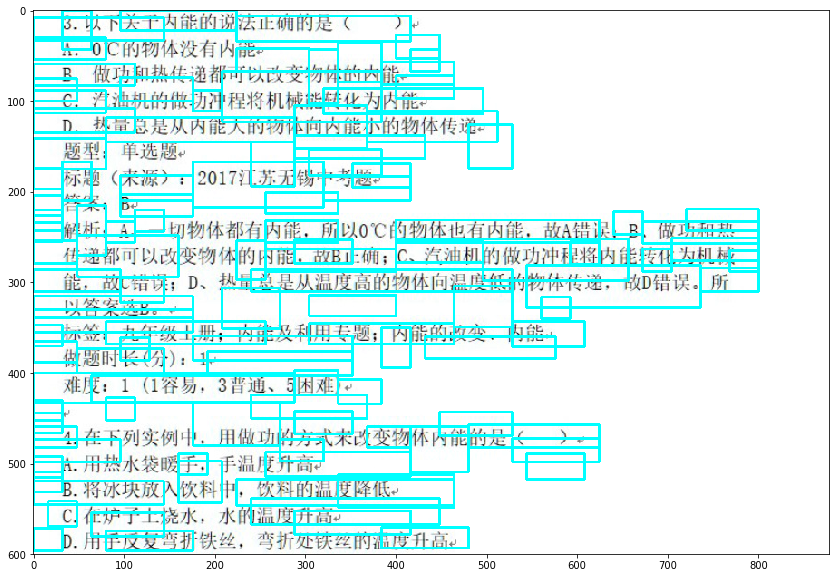

In [25]:
import lib.text_connector.text_proposal_connector as tpc
import lib.utils.nms as nms
import torch
import lib.layutils.proposal_layer as psl
import matplotlib.pyplot as plt
import cv2
import numpy as np
import importlib
importlib.reload(tpc)
importlib.reload(psl)
import time

DEBUG = False

def connect_proposal(text_proposals, scores, im_size):
    cp = tpc.TextProposalConnector()
    line = cp.get_text_lines(text_proposals, scores, im_size)
    return line


def save_results(image_name, image, line, thresh):
    im = image.copy()
    inds = np.where(line[:, -1] >= thresh)[0]
#     print('inds --->{}'.format(len(inds)))
    if len(inds) == 0:
        return
    
    for i in inds:
        bbox = line[i, :].astype(np.int)
#         print('bbox {}--> \n {}'.format(i,bbox))
        score = line[i, -1]
        cv2.rectangle(
            im, (bbox[0], bbox[1]), (bbox[6], bbox[7]),
            color=(0, 255, 255),
            thickness=2)
    plt.imshow(im,'brg')
    plt.show()
    cv2.imwrite('d:\\1.jpg',im)
    
def testConnectProposal():
    plt.rcParams['figure.figsize'] = 15, 10
    img = cv2.imread(roidb[2]['image'])
    boxes = roidb[2]['boxes']
    print(boxes)
    scores = np.ones(boxes.shape[0])
    CONF_THRESH = 0.9
    NMS_THRESH = 0.3
    print(boxes.shape)
    print(scores.shape)
    dets = np.hstack((boxes, scores[:, np.newaxis])).astype(np.float32)
    keep = nms.nms(dets, NMS_THRESH)
    dets = dets[keep,:]
    print(dets)
    line = connect_proposal(dets[:, 0:4], dets[:, 4], img.shape)
    line = line.astype(int)
    print(line)
    save_results("newimg.jpg", img, line, thresh=0.7)

def validNet(image_s,im_info):
    feat_stride = [16, ]
    ANCHOR_SCALES = [16]
    ANCHOR_RATIOS = [0.5,1,2]
    num_anchors = 10

#     blobs = data_layer.forward()
#     image = blobs['data']
#     image_src = image.copy()
#     im_info = blobs['im_info']
    image = image_s.copy()
    image = torch.from_numpy(image.transpose([0,3,1,2]))
    print('image shape --> {}'.format(image.size()))
    
    net.eval()
    net_conv = net._layers['head'](image)
    anchors, length = generate_anchors_pre(net_conv.size(2), net_conv.size(3),feat_stride=feat_stride,anchor_scales=(16,))
    anchors = torch.from_numpy(anchors)
    rpn = F.relu(net.rpn_net(net_conv))  # ( N , C, H, W）
    rpn_reshape = rpn.permute(0,2,3,1).squeeze(0)
    rpn_blstm,_ = net.rpn_bi_net(rpn_reshape)
    rpn_blstm = F.relu(rpn_blstm)  # 注意另外可以考虑采用batch normal方法对数据进行整理
    rpn_blstm_reshape = rpn_blstm.view(-1, RPN_CHANNELS)
    rpn_cls_score = net.rpn_cls_score_net(rpn_blstm)   # [W H, num_anchors*2], num_anchors = 10
    rpn_cls_score = rpn_cls_score.view(rpn_blstm.size()[0], rpn_blstm.size()[1],-1)
    rpn_cls_score = rpn_cls_score.permute(2,0,1).unsqueeze(0)
    rpn_cls_score = rpn_cls_score.permute(0,2,3,1)
    rpn_cls_score_reshape = rpn_cls_score.contiguous().view(1,rpn_cls_score.size()[1],-1,2)  
    # 得到坐标点的10个分类概率（二分类方法)
    rpn_cls_prob_reshape = F.softmax(rpn_cls_score_reshape.view(-1,2),dim=1)           # N 2 H*NUM_ANCHORS W
    rpn_cls_prob = rpn_cls_prob_reshape.view(rpn_cls_score.size()[0],
                                             rpn_cls_score.size()[1],
                                             -1,
                                             2 * num_anchors
                                            )
    
    if DEBUG:
        print('rpn_cls_score_reshape --> \n {}'.format(rpn_cls_score_reshape.size()) )
        print('rpn cls prob reshape --> \n {}'.format(rpn_cls_prob_reshape.size()))
        print('rpn_cls_score size {} --> \n {}'.format(rpn_cls_score.size(),rpn_cls_score))
        print('rpn_cls_prob size {} --> \n {}'.format(rpn_cls_prob.size(),rpn_cls_prob))
    
    rpn_bbox_pred  = net.rpn_bbox_pred_net(rpn_blstm_reshape)   # [W H, num_anchors*4], num_anchors = 10
    rpn_bbox_pred = rpn_bbox_pred.view(rpn_blstm.size()[0],rpn_blstm.size()[1],-1)
    rpn_bbox_pred = rpn_bbox_pred.unsqueeze(0)

    
    blob, scores = psl.proposal_layer(rpn_cls_prob, 
                                      rpn_bbox_pred.contiguous(),
                                      im_info,
                                      'TEST',
                                      feat_stride,
                                      anchors,
                                      num_anchors)
    return image_s, blob, scores, rpn_cls_prob, rpn_bbox_pred, rpn_cls_score,rpn_cls_prob_reshape

def showValidNet(image,im_info):
    PIXEL_MEANS = np.array([[[102.9801, 115.9465, 122.7717]]])
    image_orig = image.copy()
    image = image.astype(np.float32)
    image -= PIXEL_MEANS
    image = image.reshape(1,image.shape[0],image.shape[1],image.shape[2])
    start_time = time.time()
    with torch.no_grad():
        image_src, blob, scores , rpn_cls_prob, rpn_bbox_pred, rpn_cls_score,rpn_cls_prob_reshape = validNet(image,im_info)
    print('handle times {:.4f}'.format((time.time() - start_time)))  
    plt.rcParams['figure.figsize'] = 15, 10
    boxes = blob.data.numpy()[:,1:5]
    boxes = boxes.astype(np.int)
    score = scores.data.numpy()
    score = score.reshape(score.shape[0])
    image_new = image_src.reshape(image_src.shape[1],image_src.shape[2], image_src.shape[3])

    dets = np.hstack((boxes, score[:, np.newaxis])).astype(np.float32)
#     print('dets --> \n {}'.format(dets))
    keep = nms.nms(dets, 0.3)
    dets = dets[keep,:]
    
    line = connect_proposal(dets[:, 0:4], dets[:, 4], image_new.shape)
#     line = line.astype(int)
#     print(line)
    # image_new = image_src.reshape(image_src.shape[1],image_src.shape[2], image_src.shape[3])
    print(line[0:1])
    save_results('newimg.jpg',image_orig, line, 0.5)    
    return rpn_cls_prob, rpn_bbox_pred, rpn_cls_score,rpn_cls_prob_reshape,boxes,score, line,dets,image_new

# img_path = '/home/hecong/temp/data/txtdect/img/2.jpg'
img_path = 'd:\\2.jpg'
image = cv2.imread(img_path,cv2.IMREAD_COLOR)
im_info = [image.shape[0],image.shape[1],1]

rpn_cls_prob, rpn_bbox_pred, rpn_cls_score,rpn_cls_prob_reshape,boxes,score, line,dets,image_new  =  showValidNet(image,im_info)

# testConnectProposal()
# showValidNet(image,im_info)


In [130]:
PIXEL_MEANS = np.array([[[102.9801, 115.9465, 122.7717]]])
image = cv2.imread('d:\\2.jpg',cv2.IMREAD_COLOR)
image = image.astype(np.float32)
image -= PIXEL_MEANS
image = image.reshape(1,image.shape[0],image.shape[1],image.shape[2])
print(image.shape)

(1, 600, 878, 3)
